# Lab 1 - Computational Intelligence 2024

In [ ]:
## Kernel
# #
# C:\Users\Lorenzo Ugoccioni\Documents\PoliTo\LM - III anno\Computational Intelligence\Labs\.venv\Scripts\python.exe

In [1]:
from random import random, seed, choice
from itertools import product, accumulate
import numpy as np
import matplotlib.pyplot as plt

from functools import reduce
from tqdm.auto import tqdm
from icecream import ic

c:\Users\Lorenzo Ugoccioni\Documents\PoliTo\LM - III anno\Computational Intelligence\Labs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Cover

*Given a family of sets, find the subfamily of minimum cost that covers all the elements in the universe.*

Solve efficently these istances:
- SIZE: 100; Number of sets: 10; Density: 0.2
- SIZE: 1000; Number of sets: 100; Density: 0.2
- SIZE: 10000; Number of sets: 1000; Density: 0.2
- SIZE: 100000; Number of sets: 10000; Density: 0.1
- SIZE: 100000; Number of sets: 10000; Density: 0.2
- SIZE: 100000; Number of sets: 10000; Density: 0.3

## Initialization

In [83]:
UNIVERSE_SIZE = 100000
NUM_SETS = 10000
DENSITY = 0.1

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [84]:
# DON'T EDIT THESE LINES!
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [74]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution])).item()


def cost(solution):
    """Returns the cost of a solution (to be MINIMIZED)"""
    return COSTS[solution].sum().item()

def fitness(state):
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(UNIVERSE_SIZE)]),
        )
    )
    return valid.item(), -cost(state)

In [75]:
def tweak(state):
    new_state = state.copy()
    index = np.random.randint(0, NUM_SETS - 1)
    new_state[index] = not new_state[index]
    return new_state

def powerfull_tweak(solution):
    new_solution = solution.copy()
    index = None
    while index is None or np.random.random() < 0.4:     # 40% probability to perform a second mutation
        index = np.random.randint(0, NUM_SETS-1)
        new_solution[index] = not new_solution[index]
    return new_solution

## Dumb and Ramdom Solution

In [67]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
ic(solution)
ic(valid(solution), cost(solution))


# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
ic(valid(solution), cost(solution))

None

ic| solution: array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True,  True,  True,  True,  True,  True,  True,  True,  True,
                      True])
ic| valid(solution): True, cost(solution): 3417

## Solutions technique

In [76]:
TEMPERATURE = 1
STEEPEST_STEPS = 5
NUMBER_STEPS = 7_500

In [81]:
def simulated_annealing(temperature, current, new):
    prob_worse_sol = np.exp(-(fitness(current)[1] - fitness(new)[1])/temperature)
    np.random.random() <= prob_worse_sol
    return np.random.random() <= prob_worse_sol

def steepest_step(current_solution):
    candidates = [tweak(current_solution) for _ in range(STEEPEST_STEPS)]
    candidates_fitness = list()
    for c in candidates:
        f = fitness(c)
        #history.append(f)
        candidates_fitness.append(f)
    idx = candidates_fitness.index(max(candidates_fitness))

    # keep candidate solution that yielded the steepest ascent
    new_solution = candidates[idx]
    new_fitness = candidates_fitness[idx]
    return new_solution, new_fitness

def local_iterated_search(state):
    new_state = state.copy()
    index = None
    while index is None or np.random.random() < 0.5:     # 50% probability to perform a second mutation
        index = choice([i for i, val in enumerate(state) if val])
        new_state[index] = not new_state[index]
    return np.random.permutation(state)

In [85]:
current_state = [choice([False, True]) for _ in range(NUM_SETS)]
current_fitness = fitness(current_state)
history_fitness=[current_fitness] 
history_state=[current_state]

temperature = TEMPERATURE
used_simulated_annealing = False

for step in tqdm(range(NUMBER_STEPS)):
    if step%(NUMBER_STEPS//5) == 0:
        new_state = local_iterated_search(current_state)
    elif step%(NUMBER_STEPS//200) == 0:
        new_state, _ = steepest_step(current_state)
    else:
        new_state = powerfull_tweak(current_state)

    history_state.append(new_state)
    history_fitness.append(fitness(new_state))

    if history_fitness[-1] >= current_fitness:   # Fitness IS improving
        current_state = new_state
        current_fitness = history_fitness[-1]
        temperature = temperature ** 0.5

    else:   # Fitness IS NOT improving
        if simulated_annealing(temperature, current_state, new_state): # BUT temperature is TOO High
            current_state = new_state
            current_fitness = history_fitness[-1]
        else:
            temperature = temperature*1.2


100%|██████████| 10000/10000 [20:59<00:00,  7.94it/s] 


In [86]:
idx = history_fitness.index(max(history_fitness))

solution = history_state[idx]
solution_fitness = history_fitness[idx]
ic(solution_fitness,valid(solution), cost(solution), idx, history_fitness.index(max(history_fitness)))
None

ic| solution_fitness: (100000, -47446550.337716416)
    valid(solution): True
    cost(solution): 47446550.337716416
    idx: 9993
    history_fitness.index(max(history_fitness)): 9993


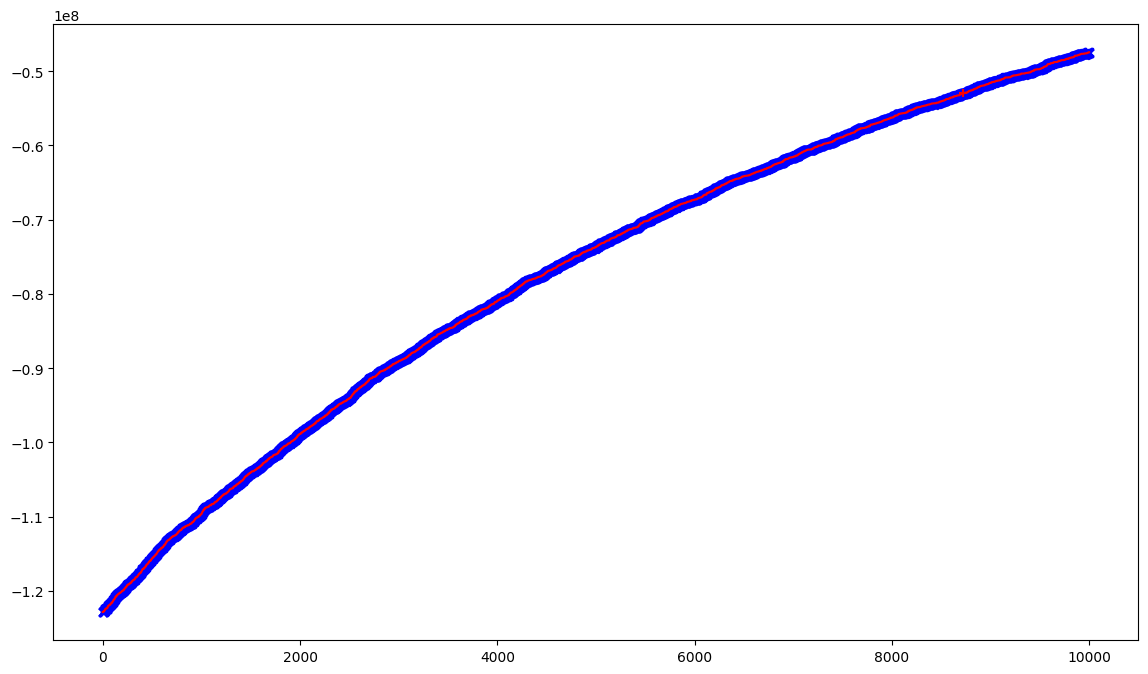

In [88]:
plt.figure(figsize=(14,8))
plt.scatter(range(len(history_fitness)), [value for _, value in history_fitness], marker="x", color="blue")
plt.scatter(8722, history_fitness[8722][1], marker="+", color="red")
plt.plot(range(len(history_fitness)), list(accumulate([value for _, value in history_fitness], max)),color="red")
plt.show()